In [1]:
import pandas as pd
from custom_loader import ShoeDataset
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from helper import loader_show_image, model_sample_output, load_checkpoint, test_model
import torch
from torchvision import models
from tqdm.auto import tqdm
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from collections import OrderedDict

In [2]:
# same dataloader business, but only with test dataset this time

batch_size = 64
test_csv_file = 'test_clean.csv'
root_dir = 'sneaker_image_clean/'

test_transform = transforms.Compose([transforms.Resize((224, 336)),
                                     transforms.ToTensor(),
                                     transforms.Normalize([0.485, 0.456, 0.406],
                                                          [0.229, 0.224, 0.225])])

In [3]:
valid_test_dataset = ShoeDataset(test_csv_file, root_dir, transform = test_transform)
_, test_dataset = torch.utils.data.random_split(valid_test_dataset, [1871, 1871])
test_loader = DataLoader(dataset = test_dataset, batch_size = batch_size)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


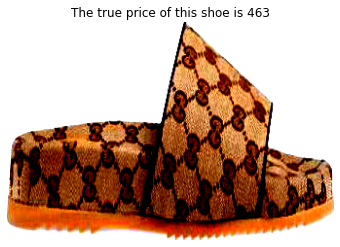

In [4]:
#draw random sample from test_loader for visualization, rerun this cell to shuffle through the loader
loader_show_image(test_loader)

In [2]:
# define GPU or CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

criterion = nn.MSELoss()

In [3]:
# load in your saved checkpoints, here I am comparing between three

model1 = load_checkpoint('best_model_vgg_nf.pth').to(device)
'''model2 = load_checkpoint('best_model_vgg_f.pth').to(device)
model3 = load_checkpoint('best_model.pt').to(device)'''

loading model...
model loaded!


"model2 = load_checkpoint('best_model_vgg_f.pth').to(device)\nmodel3 = load_checkpoint('best_model.pt').to(device)"

In [36]:
# model1 = VGG16 with no freeze, you can see this has the lowest test_error between the three models
test_model(model1, test_loader, device, criterion)


Test Loss: 33832.713..
Test Error: 31.91..


In [37]:
# model1 = VGG16 withe freeze
test_model(model2, test_loader, device, criterion)


Test Loss: 34078.056..
Test Error: 35.57..


In [38]:
test_model(model3, test_loader, device, criterion)


Test Loss: 31467.001..
Test Error: 36.04..


In [4]:
class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
        Returns:
            Tensor: Normalized image.
        """
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
            # The normalize code -> t.sub_(m).div_(s)
        return tensor

In [5]:
def model_sample_output(image_path, model, device):

    img_transforms = transforms.Compose([transforms.Resize((224, 336)),
                                     transforms.ToTensor(),
                                     transforms.Normalize([0.485, 0.456, 0.406],
                                                          [0.229, 0.224, 0.225])])
    
    #transform the test image as it was trained
    images = img_transforms(Image.open(image_path)).unsqueeze(0).to(device)
    
    model.eval()

    # forward pass to get output
    output_preds = model.forward(images)
    
    output_preds = output_preds.view(output_preds.size()[0], -1).to(device)

    visualize_output(images, output_preds)

In [6]:
def visualize_output(test_images, pred_outputs, actual_outputs=None):
    plt.figure(figsize=(11, 8.5))

    # un-transform the image data
    unnorm = UnNormalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
    image = test_images.cpu()  # get the image from it's Variable wrapper
    image = unnorm(image)
    image = image.numpy()  # convert to numpy array from a Tensor

    # un-transform the predicted price
    predicted_output = pred_outputs.data.cpu()
    predicted_output = predicted_output.numpy()[0]
    predicted_output = abs(float(predicted_output))

    # display image and prediction
    plt.title('The predicted price for this shoe is \${} USD'.format(np.round(predicted_output, 2)))
    plt.imshow(np.squeeze(image).transpose((1,2,0)))

    plt.axis('off');

    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


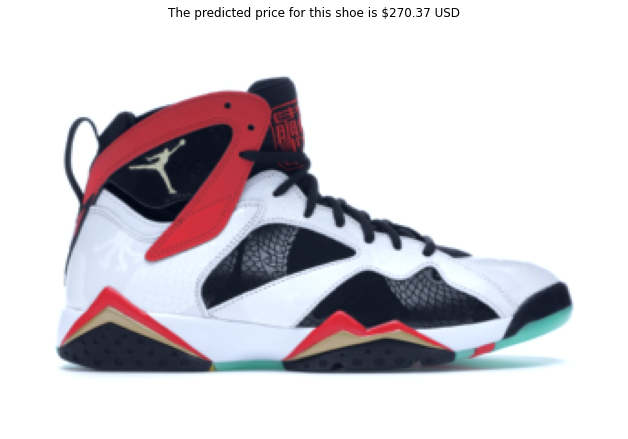

In [18]:
# test your model on a random image!
model_sample_output('test9.jpg', model1, device)

In [ ]:
models.den